## Imports

In [156]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import multiprocessing as mp

from datetime import date, timedelta
from tqdm.auto import tqdm

tqdm.pandas()

## Reference Line Selection

In [86]:
# Does not work! Inconsistent line
'''df = pd.read_parquet('Merges/PETERSON_MASTER.parquet')
df.lat = df.lat.round(4)
df.lon = df.lon.round(4)

latlon_mode = pd.DataFrame(df.groupby(['lat', 'lon'], as_index=False).lat.value_counts().sort_values(by='count', ascending=False))
latlon_mode = latlon_mode[latlon_mode.lat > 0]
latlon_mode = latlon_mode.head(10000)
print(latlon_mode)'''

df = pd.read_parquet('Merges/PETERSON_CLEANED.parquet')
temp = df.groupby('file').file.value_counts().sort_values(ascending=False)
df_filter = df[df.file == '14322dat.txt']
df_filter = df_filter.reset_index(drop=True).reset_index().rename(columns={'index': 'p_id'})
#df_filter.to_parquet('ref_line_temp.parquet', engine='auto')
#print(temp.head(10))

# Candidates
# 06074
# 14322 (current)
# 09139
# 06318
# 11040

Verification:

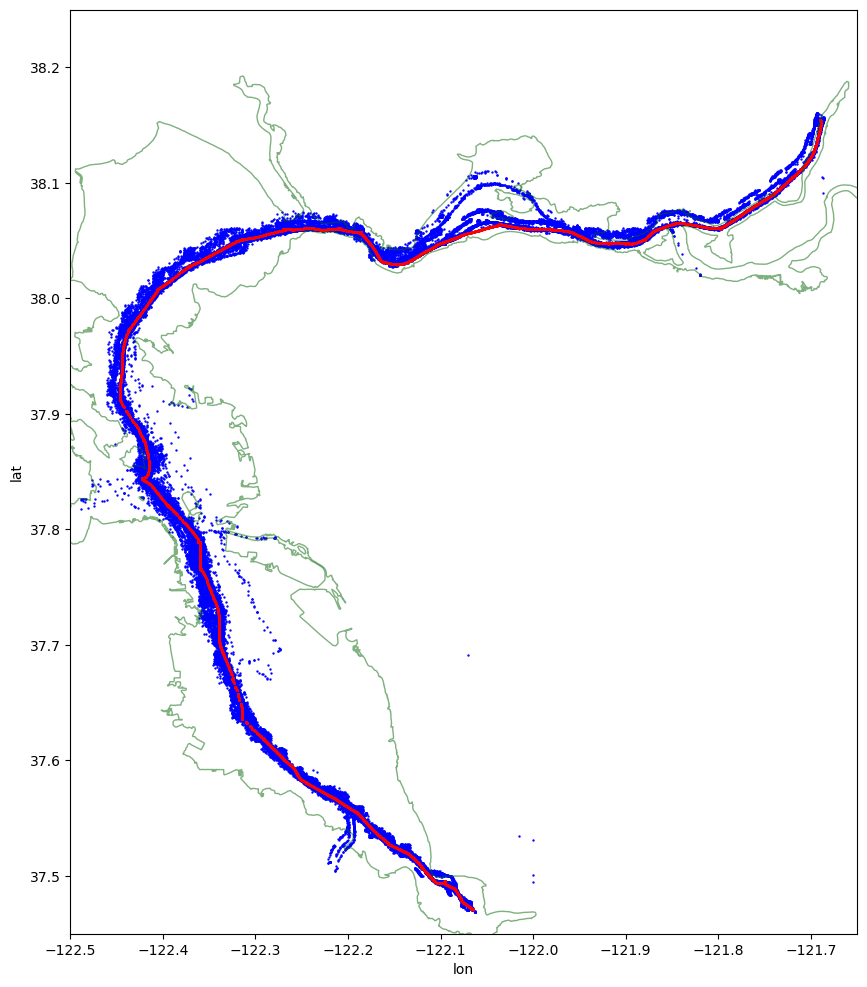

In [73]:
df = pd.read_parquet('Merges/PETERSON_CLEANED.parquet').sample(n=100000)

shape = gpd.read_file('Shapefiles/bays_estuaries.shp').to_crs(4269)

fig, ax = plt.subplots(figsize=(12, 12))
#shape = shape[shape.AREA_NAME == 'Other']
shape.plot(ax=ax, color='darkgreen', alpha=0.5, edgecolor='black', linewidth=1.0)
df.plot(ax=ax, kind='scatter', x='lon', y='lat', color='blue', s=2, marker='.')
df_filter.plot(ax=ax, kind='scatter', x='lon', y='lat', color='red', s=2, marker='.')

plt.xlim(-122.5, -121.65)
plt.ylim(37.45, 38.25)
plt.show()

## Spatial Coercion

In [160]:
# This function coerces all lat/lon points from the supplied dataframe (PETERSON_MASTER eventually) to the closest
# point in the reference dataframe, which is itself a hand selected 'average' and complete looking sampling run. 

# 267m runtime on 8760 x 8413 (ref x dataset) points
# 9m with filtering
#11040dat.txt
resultdf = pd.read_parquet('Merges/PETERSON_CLEANED.parquet').sort_values(by='datetime')#.sample(10000, random_state=123)
refpoints = pd.read_parquet('REF_LINE.parquet')#.sample(n=1000)
#resultdf = df[df.file == '14322dat.txt'].sort_values(by='datetime')#.sample(n=1000, random_state=123)
print(f'Dataset points: {len(resultdf)}')
print(f'Reference points: {len(refpoints)}')

#resultdf = resultdf[(resultdf.lat != 0) & (resultdf.lon != 0)]

print(resultdf.lat.max(), resultdf.lat.min())
print(resultdf.lon.max(), resultdf.lon.min())

Dataset points: 2492229
Reference points: 8760
38.16083 36.6075
-120.0683 -125.7333


In [161]:
def coerce(lat, lon):
    # Filter refpoints because we know the closest point will be within a certain distance of passed lat/lon
    # This avoids quadratic checking of every point in the frame
    lat_step = .0005 
    lon_step = .0005
    
    filteredref = refpoints[refpoints.lat.between(lat - lat_step, lat + lat_step)]
    filteredref = filteredref[filteredref.lon.between(lon - lon_step, lon + lon_step)]

    # Rare case where filteredref is empty because there are no lat/lon points returned from between()
    # In this case we increase window and try again
    while filteredref.empty:
        lat_step += .001
        lon_step += .001
        filteredref = refpoints[refpoints.lat.between(lat - lat_step, lat + lat_step)]
        filteredref = filteredref[filteredref.lon.between(lon - lon_step, lon + lon_step)]

    filteredref['dist'] = filteredref.apply(lambda x: geopy.distance.geodesic((lat, lon), (x.lat, x.lon)).m, axis=1)
    index = filteredref.dist.idxmin()
    nearest_p_lat = filteredref.lat[index] 
    nearest_p_lon = filteredref.lon[index]
    dist = filteredref.dist.min()
    p_id = filteredref.at[index, 'p_id']
    
    return nearest_p_lat, nearest_p_lon, dist, p_id

In [162]:
resultdf[['new_lat', 'new_lon', 'dist_m', 'p_id']] = resultdf.progress_apply(lambda x: coerce(x.lat, x.lon), axis=1).apply(pd.Series)

# Confirm that all new lat/lon points exist on the reference line
assert(False not in (resultdf.new_lat.isin(refpoints.lat).values))
assert(False not in (resultdf.new_lon.isin(refpoints.lon).values))

#resultdf.to_parquet('Merges/test_spatial_coercion.parquet', engine='auto')
try:
    resultdf.to_parquet('Merges/FULL_PETERSON_COERCION.parquet', engine='auto')
except Exception as e:
    print(e)

  0%|          | 0/2492229 [00:00<?, ?it/s]

In [124]:
print(f'Avg lat discrepancy: {abs(resultdf.lat - resultdf.new_lat).mean()}')
print(f'Avg lon discrepancy: {abs(resultdf.lon - resultdf.new_lon).mean()}')
print(f'Unique ref points used: {resultdf.p_id.nunique()}')
print(f'Average coercion distance: {resultdf.dist_m.mean()}m')

Avg lat discrepancy: 0.001794475000000034
Avg lon discrepancy: 0.0017648433333333627
Unique ref points used: 3162
Average coercion distance: 267.52510332437197m


Verification:

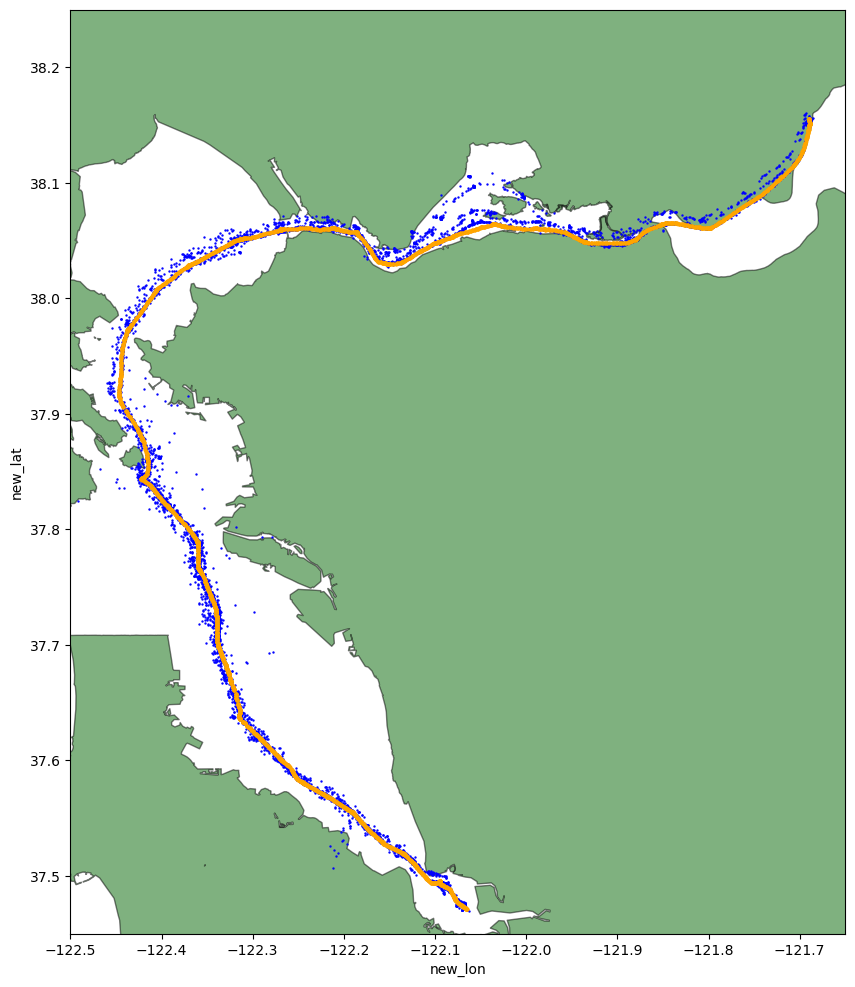

In [127]:
df = pd.read_parquet('Merges/test_spatial_coercion.parquet').sort_values(by='datetime')
fig, ax = plt.subplots(figsize=(12, 12), sharex=True, sharey=True)

# Optional filter by distance from line
# df = df[df['dist_m' < 1000]

shape = gpd.read_file('Shapefiles/bayarea_general.shp')
shape = shape.to_crs(4269)
shape = shape[shape.AREA_NAME == 'Other']
shape.plot(ax=ax, color='darkgreen', alpha=0.5, edgecolor='black', linewidth=1.0)

# Reference line RED
df_filter.plot(ax=ax, kind='scatter', x='lon', y='lat', color='red', s=2, marker='.')
# Original line BLUE
df.plot(ax=ax, kind='scatter', x='lon', y='lat', color='blue', s=2, marker='.')
# Coerced line ORANGE
df.plot(ax=ax, kind='scatter', x='new_lon', y='new_lat', color='orange', s=10, marker='.')

plt.xlim(-122.5, -121.65)
plt.ylim(37.45, 38.25)
plt.show()

## Cummulative Distance
NOTE: This distance is assigned by locating the corresponding lat/lon points on the reference line, and using that line's distance from start rather than calculating a new one, as not all boat paths are monodirectional

In [128]:
resultdf = pd.read_parquet('Merges/test_spatial_coercion.parquet').sort_values(by='datetime')
refpoints = pd.read_parquet('REF_LINE.parquet')

def assign_cumm_dist(p_id):
    temp = refpoints[refpoints.p_id == p_id]
    dist = temp.values[0][23]
    return dist

resultdf['d_from_start'] = resultdf.progress_apply(lambda x: assign_cumm_dist(x.p_id), axis=1)
#print(resultdf.head())
#print(refpoints.tail())

  0%|          | 0/10000 [00:00<?, ?it/s]

Verification:

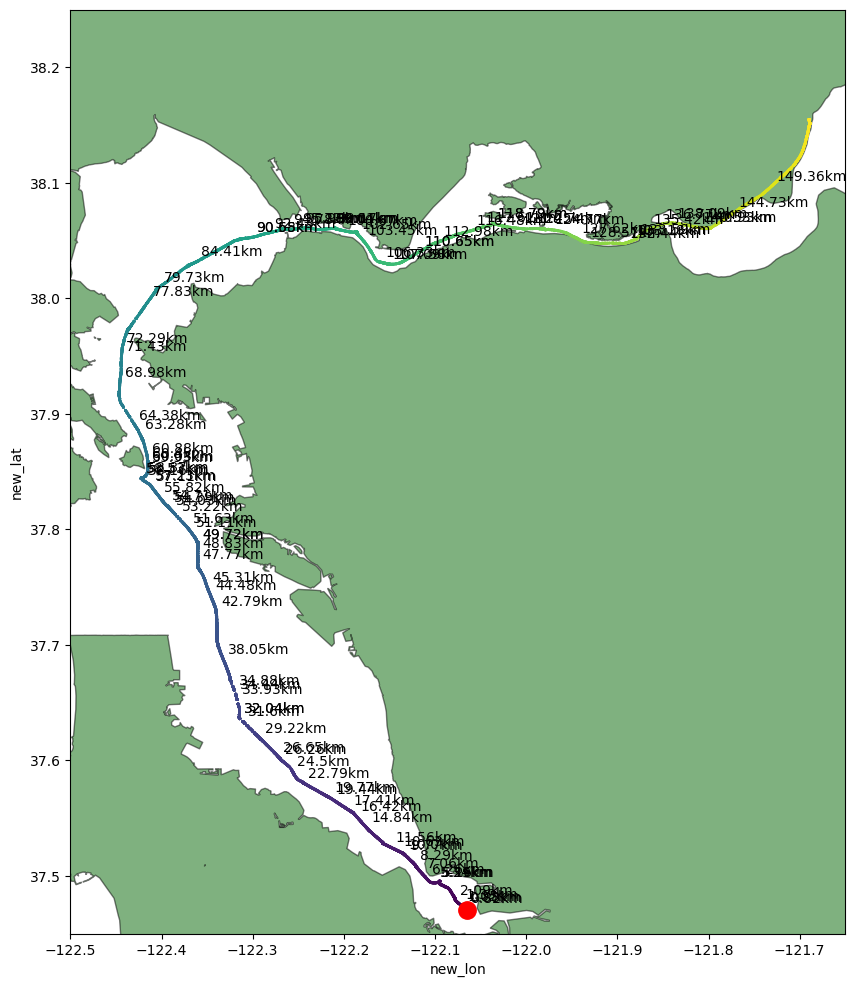

In [130]:
index = refpoints.lat.idxmin()
start_lat, start_lon = (refpoints.lat[index], refpoints.lon[index])
prev_lat, prev_lon = (refpoints.lat[index], refpoints.lon[index])

fig, ax = plt.subplots(figsize=(12, 12), sharex=True, sharey=True)

shape = gpd.read_file('Shapefiles/bayarea_general.shp')
shape = shape.to_crs(4269)
shape = shape[shape.AREA_NAME == 'Other']
shape.plot(ax=ax, color='darkgreen', alpha=0.5, edgecolor='black', linewidth=1.0)

# Start Point
plt.plot(start_lon, start_lat, color='red', markersize=25, marker='.')
# Distance
resultdf.plot(ax=ax, kind='scatter', x='new_lon', y='new_lat', color=resultdf.d_from_start, s=5, marker='.')

temp = resultdf.reset_index(drop=True)
for i, row in temp.iterrows():
    if not i % 100:
        plt.annotate(f'{round(row.d_from_start, 2)}km', (row.new_lon + .005, row.new_lat + .005))

plt.xlim(-122.5, -121.65)
plt.ylim(37.45, 38.25)
plt.show()

## Station Coercion
Verification:

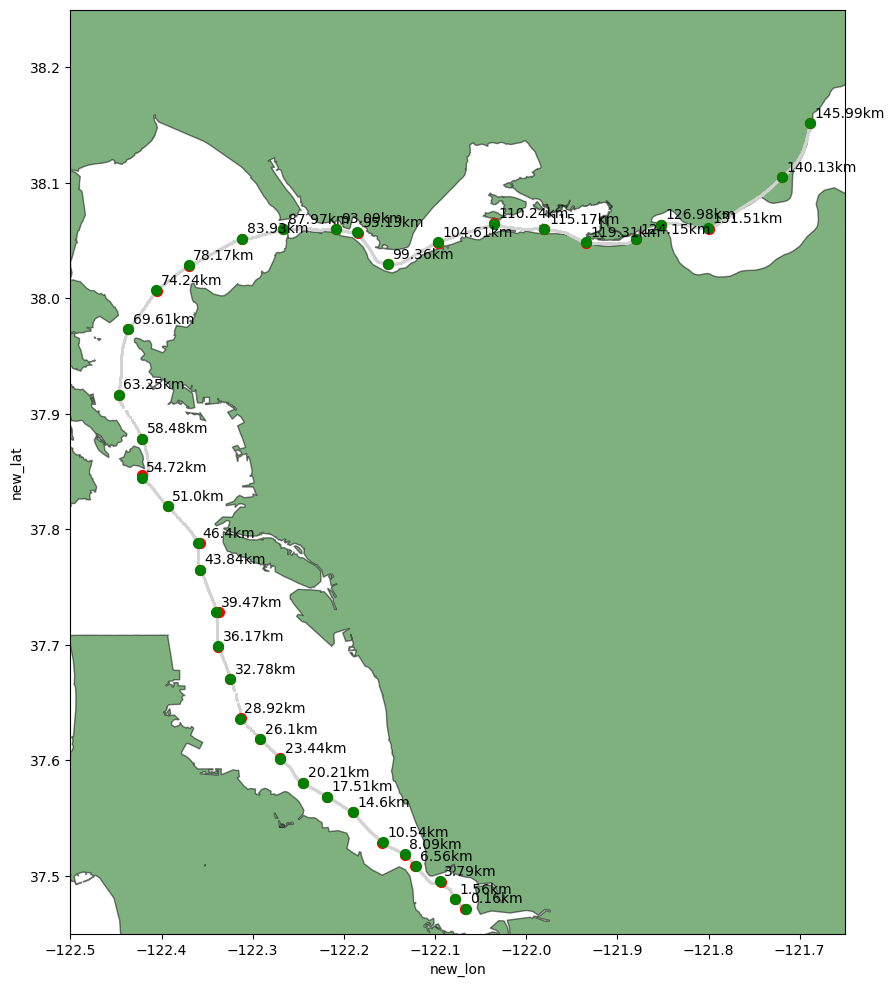

In [44]:
stationdf = (pd.read_csv('stationlocations.csv'))

stationdf['temp'] = stationdf.apply(lambda x: coerce(x.lat, x.lon), axis=1)
stationdf[['new_lat', 'new_lon']] = stationdf.temp.apply(pd.Series)
stationdf = stationdf.drop(columns='temp')

assert(False not in (stationdf.new_lat.isin(refpoints.lat).values))
assert(False not in (stationdf.new_lon.isin(refpoints.lon).values))

fig, ax = plt.subplots(figsize=(12, 12), sharex=True, sharey=True)

shape = gpd.read_file('Shapefiles/bayarea_general.shp')
shape = shape.to_crs(4269)
shape = shape[shape.AREA_NAME == 'Other']
shape.plot(ax=ax, color='darkgreen', alpha=0.5, edgecolor='black', linewidth=1.0)

# Reference line
df_filter.plot(ax=ax, kind='scatter', x='lon', y='lat', color='lightgrey', s=2, marker='.')
# Original stations
stationdf.plot(ax=ax, kind='scatter', x='lon', y='lat', color='red', s=200, marker='.')
# Coerced stations
stationdf.plot(ax=ax, kind='scatter', x='new_lon', y='new_lat', color='green', s=200, marker='.')

for i, row in stationdf.iterrows():
    plt.annotate(f'{round(row.d_from_start, 2)}km', (row.new_lon + .005, row.new_lat + .005))


plt.xlim(-122.5, -121.65)
plt.ylim(37.45, 38.25)
plt.show()

## Point Proximity to Station Selection
Select all points within N meters from a given station

In [150]:
stationdf = pd.read_csv('stationlocations.csv')
sampledf = pd.read_parquet('Merges/test_spatial_coercion.parquet')

def nearest_station(lat, lon):
    lat_step = .1 
    lon_step = .1
    
    filteredref = stationdf[stationdf.new_lat.between(lat - lat_step, lat + lat_step)]
    filteredref = filteredref[filteredref.new_lon.between(lon - lon_step, lon + lon_step)]

    while filteredref.empty:
        lat_step += .1
        lon_step += .1
        filteredref = stationdf[stationdf.new_lat.between(lat - lat_step, lat + lat_step)]
        filteredref = filteredref[filteredref.new_lon.between(lon - lon_step, lon + lon_step)]

    filteredref['dist'] = filteredref.apply(lambda x: geopy.distance.geodesic((lat, lon), (x.new_lat, x.new_lon)).m, axis=1)
    index = filteredref.dist.idxmin()
    dist = filteredref.dist.min()
    station_id = filteredref.at[index, 'Station_Number']

    return dist, station_id

sampledf[['d_from_station', 'station_id']] = sampledf.progress_apply(lambda x: nearest_station(x.new_lat, x.new_lon), axis=1).apply(pd.Series)

sampledf.to_parquet('Merges/test_spatial_coercion.parquet', engine='auto')

  0%|          | 0/10000 [00:00<?, ?it/s]

## Point Proximity to Station Verification

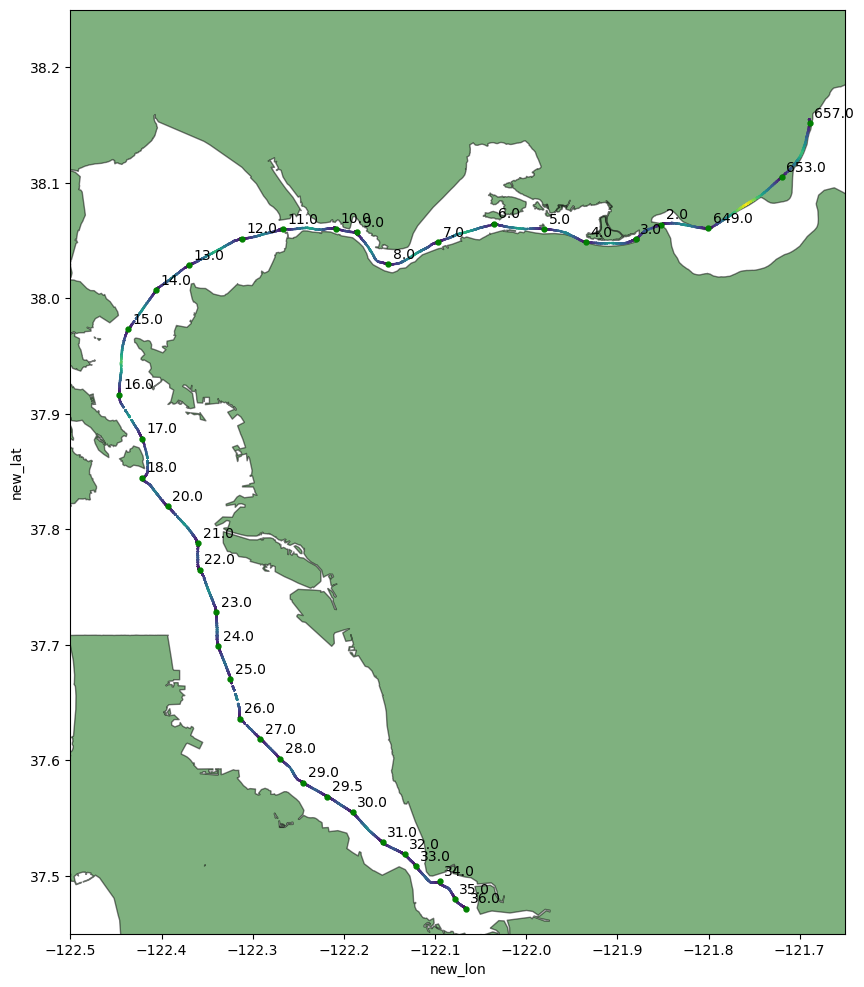

In [155]:
df = pd.read_parquet('Merges/test_spatial_coercion.parquet')
#df = df[df.station_id == 653.0]

stationdf = pd.read_csv('stationlocations.csv')

fig, ax = plt.subplots(figsize=(12, 12), sharex=True, sharey=True)

shape = gpd.read_file('Shapefiles/bayarea_general.shp')
shape = shape.to_crs(4269)
shape = shape[shape.AREA_NAME == 'Other']
shape.plot(ax=ax, color='darkgreen', alpha=0.5, edgecolor='black', linewidth=1.0)

# Sample points
df.plot(ax=ax, kind='scatter', x='new_lon', y='new_lat', color=df.d_from_station, s=2, marker='.')
# Stations
stationdf.plot(ax=ax, kind='scatter', x='new_lon', y='new_lat', color='green', s=50, marker='.')

for i, row in stationdf.iterrows():
    plt.annotate(f'{row.Station_Number}', (row.new_lon + .005, row.new_lat + .005))

plt.xlim(-122.5, -121.65)
plt.ylim(37.45, 38.25)
plt.show()